## Demo of Variational Autoencoders

This is a basic demo of variational autoencoders on MNIST data using TensorFlow and Keras, adapted from the post [Variational AutoEncoders and Image Generation with Keras](https://dropsofai.com/variational-autoencoders-and-image-generation-with-keras/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
# Re-enable eager execution
# tensorflow.compat.v1.enable_eager_execution()

### Load data and display a few images

Training data shape: X=(60000, 28, 28), y=(60000,)
Testing data shape: X=(10000, 28, 28), y=(10000,)


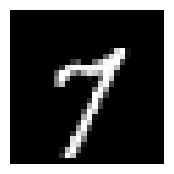

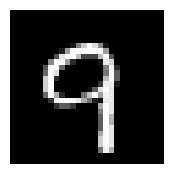

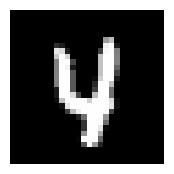

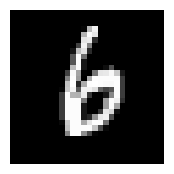

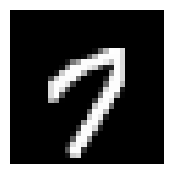

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shape: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shape: X=%s, y=%s' % (testX.shape, testy.shape))

ind = np.random.choice(np.arange(len(trainX)), size=5)
for i in ind:
    plt.figure(figsize=(2, 2))
    plt.imshow(trainX[i], cmap='gray')
    plt.axis('off')
    plt.title('')
plt.show()

### Reshape the data to have one channel

In [4]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))


# Building the VAE

### Encoder network

This is the network that outputs the variational mean and variance. It has three convolutional layers and a dense layer.


In [5]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

### Sampling from the variational distribution

This applies the "reparameterization trick" by sampling a standard Gaussian, scaling by the noise level and adding the mean:

$$ Z  = \mu(x) + \sigma(x) \epsilon$$

Since the network outputs the log of the variance, we exponentiate it:

$$ \sigma(x) = \exp\left(\frac{1}{2} \log \sigma^2(x)\right)$$

In [6]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [7]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='variational_mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='variational_log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [8]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │      1,664 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 10, 10,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 32)  │     18,464 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 2)         │         34 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 2)         │         34 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ variational_mean… │
│                     │                   │            │ variational_log_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,652 (225.20 KB)

 Trainable params: 57,652 (225.20 KB)

 Non-trainable params: 0 (0.00 B)

## Generative network or decoder

In [9]:
decoder_input = tensorflow.keras.layers.Input(shape=(2,))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [10]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 5, 5, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 12, 12, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,577 (439.75 KB)

 Trainable params: 112,577 (439.75 KB)

 Non-trainable params: 0 (0.00 B)

## Combining

In [11]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [12]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

### Loss Function (Reconstruction Loss + KL-loss)

As not mentioned in class, when generating data, we can add noise. Thus the model is
$ Z \sim N(0,I)$ and then $X | z = N(G(z), \gamma^2 I)$ where the noise level is $\gamma$.
In this case we add a mean-squared error term to the loss function. And MSE minus ELBO is MSE + KL(q, p).

In [25]:
def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [ ]:
# Solve the issue with KL loss in Keras 3
from keras import ops, layers, Model
from keras.losses import mean_squared_error as mse

# --- KL layer (log-variance assumed) ---
class KLLoss(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs  # logvar = log(σ^2)
        # KL per sample: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
        kl_per_sample = -0.5 * ops.sum(1.0 + logvar - ops.square(mu) - ops.exp(logvar), axis=-1)
        self.add_loss(ops.mean(kl_per_sample))  # scalar KL
        return inputs  # pass-through

# 1) Create the KL node
kl_node = KLLoss(name="kl_loss")([distribution_mean, distribution_variance])

# 2) Tie the KL node into the forward graph but keep output = decoded
decoded = layers.Lambda(lambda xs: xs[0], name="with_kl")([decoded, kl_node])

# 3) (Re)build the model so the KL loss is included
autoencoder = tensorflow.keras.models.Model(input_data, decoded, name="autoencoder_with_kl")

# 4) reconstruction loss
def reconstruction_loss(y_true, y_pred):
    reconstruction = mse(y_true, y_pred)      # per-example, per-position
    reconstruction_batch = ops.mean(reconstruction)  # global mean
    return reconstruction_batch * 28 * 28

autoencoder.compile(optimizer="adam", loss=reconstruction_loss)

## Training

In [16]:
# autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "autoencoder_with_kl"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │      1,664 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 10, 10,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 32)  │     18,464 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 2)         │     57,652 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 2)         │         34 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 2)         │         34 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 28, 28, 1) │    112,577 │ functional[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_loss (KLLoss)    │ [(None, 2),       │          0 │ variational_mean… │
│                     │ (None, 2)]        │            │ variational_log_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ with_kl (Lambda)    │ (None, 28, 28, 1) │          0 │ functional_1[0][… │
│                     │                   │            │ kl_loss[0][0],    │
│                     │                   │            │ kl_loss[0][1]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 170,229 (664.96 KB)

 Trainable params: 170,229 (664.96 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
autoencoder.fit(train_data, train_data, epochs=10, batch_size=64, validation_data=(test_data, test_data))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 208s 217ms/step - loss: 49.5306 - val_loss: 42.7278
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 255s 209ms/step - loss: 41.6348 - val_loss: 40.7416
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 200s 208ms/step - loss: 40.3302 - val_loss: 39.7242
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 209ms/step - loss: 39.8594 - val_loss: 39.4587
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 195s 208ms/step - loss: 39.2064 - val_loss: 38.9153
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 207ms/step - loss: 38.8962 - val_loss: 38.5244
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 203s 208ms/step - loss: 38.5784 - val_loss: 38.8125
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 199s 205ms/step - loss: 38.3661 - val_loss: 38.3835
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 202s 206ms/step - loss: 38.2201 - val_loss: 38.3322
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 205ms/step - loss: 38.0434 - val_loss: 37.9414


Real Test Images


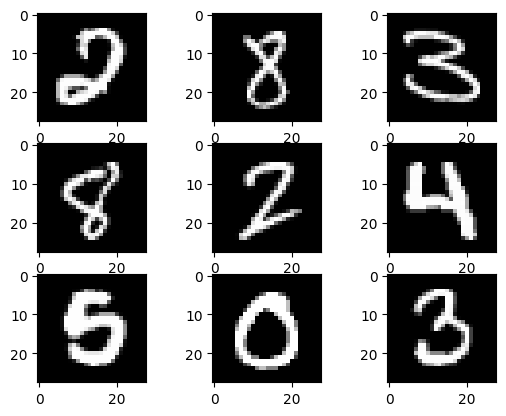

Reconstructed Images with Variational Autoencoder
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


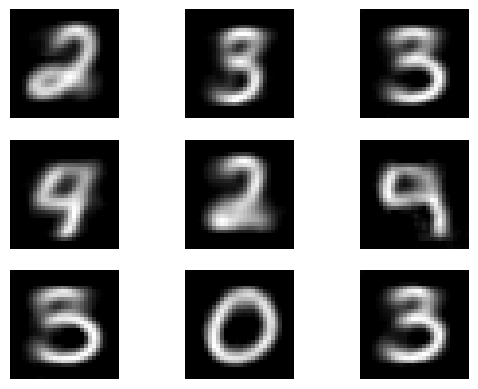

In [18]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
    plt.axis('off')
plt.show()

## Latent feature clusters

In [19]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

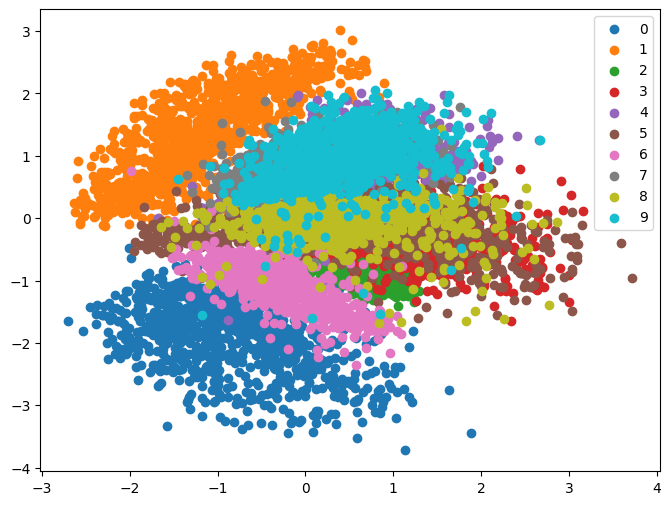

In [20]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]
plt.figure(figsize=(8, 6))
for c in np.unique(z):
    i = np.where(z == c)
    plt.scatter(np.array(x)[i], np.array(y)[i], label=c)
plt.legend()
plt.show()

## Image Generation

In [21]:
generator_model = decoder_model

In [22]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

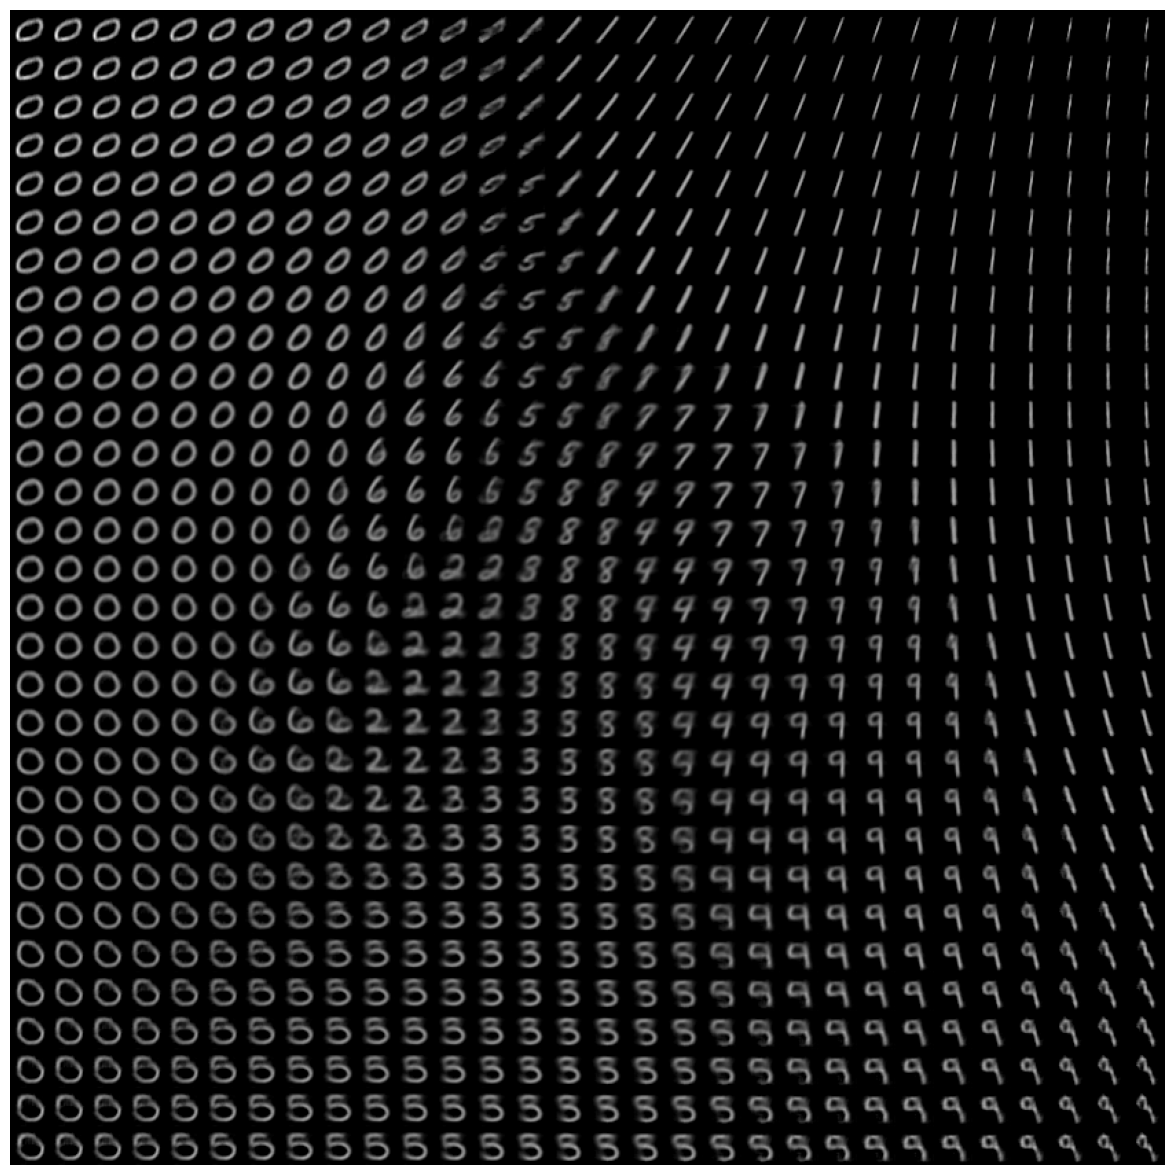

In [23]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.axis('off')
plt.show()